In [64]:
from sqlite3 import connect
import datetime as dt
import functools
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table, QTable, join
from astropy.time import Time
import astropy.units as u
import  astroplan as ap # import FixedTarget, Observer, AltitudeConstraint, AirmassConstraint, AtNightConstraint, is_observable
import pandas as pd

conn = connect("../django/QuadEBdb/db.sqlite3")

targets = pd.read_sql("select * from tom_target;", conn, index_col="id")

list_membership = pd.read_sql(
    "select tl.name, tlt.target_id from tom_targetlist tl join tom_targetlist_targets tlt on tlt.targetlist_id = tl.id;",
    conn,
)


In [65]:
targets[list(list_membership.groupby("name").groups.keys())] = False

for i, membership in list_membership.iterrows():
    targets.at[membership["target_id"], membership["name"]] = True

targets.loc[5]


KeyError: 5

In [431]:
hqnd = {
    "TIC 123098844",
    "TIC 264402353",
    "TIC 265274458",
    "TIC 278352276",
    "TIC 284814380",
    "TIC 328181241",
    "TIC 391620600",
    "TIC 414026507",
    "TIC 441794509",
    "TIC 454140642",
    "TIC 52856877",
}
featured = {
    "TIC 470710327",
    "TIC 89278612",
}


dim_hqnd = {
    "TIC 459959916",
    "TIC 309262405",
    "TIC 327885074",
    "TIC 269811101",
}

resolved = {
    "TIC 427092089",
    "TIC 336882813",
    "TIC 283940788",
    "TIC 322727163",
    # "TIC 344541836",
    "TIC 307119043",
    "TIC 266771301",
    "TIC 375325607",
    "TIC 89278612",
    "TIC 25818450",
    "TIC 470710327",
    "TIC 389836747",
    # "TIC 239872462",
    "TIC 367448265",
    # "TIC 286470992",
}

my_tics = hqnd | featured | dim_hqnd | resolved

selected = QTable.from_pandas(targets[
    targets["local_id"].isin(my_tics)
].sort_values(by=["ra"])[["local_id", "ra", "dec", "pmra", "pmdec", "magnitude"]])

print(len(hqnd), len(dim_hqnd), len(resolved), len(my_tics))


priority_info = QTable(rows=[
    (tic, "Highest") if tic in featured else
    (tic, "High") if tic in dim_hqnd else
    (tic, "Medium") if tic in hqnd else
    (tic, "Low")
    for tic in my_tics], names=("TargetName", "Priority"))
priority_info

config_info = pd.read_csv("../Files/LBT Observing Files/PEPSI configuration info.txt", sep=";")
config_info["ExposureTime"] = config_info.apply(lambda x: x["ExposureTime"].replace("1x", "").replace("sec", ""), axis=1)
config_info["ExposureTime"] = config_info.apply(lambda x: int(x["ExposureTime"]) * (4 if x["TargetName"] in hqnd else 1), axis=1)
config_info["ExecutionTime"] = config_info.apply(lambda x: int(x["ExposureTime"]) + 140, axis=1)
config_info["ExecutionTime"] = config_info.apply(lambda x: f"{x["ExecutionTime"]:4d} sec = {x["ExecutionTime"]/60:4.1f}min", axis=1)
config_info["ExposureTime"] = config_info.apply(lambda x: f"1x{x["ExposureTime"]:4d}sec", axis=1)

added_info = QTable(rows=[
    (tic, "*") if tic in (dim_hqnd | resolved) else
    (tic, " ")
    for tic in my_tics], names=("TargetName", "A"))

config_info = QTable.from_pandas(config_info)
extra_info = join(config_info, priority_info, keys="TargetName")
extra_info = join(extra_info, added_info, keys="TargetName")
selected = join(extra_info, selected, keys_left="TargetName", keys_right="local_id",)



11 4 12 27


In [430]:
qselected = selected["TargetName", "A", "ra", "dec", "magnitude", "pmra", "pmdec", "Mode", "ExposureTime", "ExecutionTime", "Priority", "Notes"]
qselected["TargetName"].info.format = "<12s"
qselected["A"].format = "<1s"
qselected["dec"] *= u.deg
qselected["dec"] = [
    Angle(x).to_string(unit=u.deg, decimal=False, precision=2, sep=":", alwayssign=True).format(":>").rjust(12)
    for x in qselected["dec"]
]
qselected.rename_column("dec", "DEC (J2000)")
qselected["magnitude"].format = "10.2f"
qselected.rename_column("magnitude", "Gmag")
qselected["pmra"].format = "8.2f"
qselected.rename_column("pmra", "pmRA")
qselected["pmdec"].format = "9.2f"
qselected.rename_column("pmdec", "pmDEC")
qselected["Mode"].format = "<18s"
qselected["ExposureTime"].format = "<14s"
qselected["ExecutionTime"].format = "<20s"
qselected["Priority"].format = "<8s"
qselected["Notes"].format = "<42s"

# qselected = join(qselected, config_info.loc[my_tics])
# qselected["Configuration"].format = "<106s"
# qselected.rename_column("Configuration", "Mode               ExposureTime   ExecutionTime       Priority     Notes                                 ")

#put ra last because the join operation screws up the row sorting
qselected["ra"] *= u.deg
qselected.sort("ra")
qselected["ra"] = [
    " " + Angle(x).to_string(unit=u.hour, decimal=False, precision=2, sep=":").rjust(11) + "   "
    for x in qselected["ra"]
]
qselected.rename_column("ra", "RA (J2000)")

qselected.pprint_all(max_width=200)
len(qselected)

  TargetName   A     RA (J2000)   DEC (J2000)     Gmag      pmRA     pmDEC          Mode         ExposureTime     ExecutionTime     Priority                   Notes                   
------------- --- --------------- ------------ ---------- -------- --------- ------------------ -------------- -------------------- -------- ------------------------------------------
TIC 283940788 *     0:35:24.34    +62:54:05.74      11.73    -2.73     -0.15 F300/CDII/CDVI     1x 132sec       272 sec =  4.5min   Low      companion with sep=0.5", PA=245, dmag=3.8 
TIC 284814380       0:47:27.28    +64:49:04.86      12.02    -2.56     -0.24 F300/CDII/CDVI     1x 768sec       908 sec = 15.1min   Medium   --                                        
TIC 307119043 *     0:59:18.61    +51:13:17.91       9.98     7.56     -4.11 F300/CDII/CDVI     1x  60sec       200 sec =  3.3min   Low      companion with sep=0.8", PA=158, dmag=1.8 
TIC 52856877        1:09:20.23    +61:02:28.48      10.85     3.22     -1.72 F30

27

In [393]:
foo = [380,200,200,200,200,380,380,320,680,200,980,200,200,380,260,320,200,200,200,200,260,200,620,380,200,740,260,]
import numpy as np
np.sum(foo)/3600

2.4833333333333334

In [137]:
t = fits.open("s1s.tab.fits")
# t.info()
data = t[1].data
# data.tolist()
t[1].columns
# t[1]["TFIELDS"]=10
import numpy as np
columns = ["File", "Ext", "Date-obs", "UT-obs", "Exptime", "Imagetyp", "Object", "Crosdis", "Fiber"]
t = Table([data[field] for field in columns], names=columns)
t.sort("UT-obs")
t[11]["UT-obs"] / 3600

7.2023774944245815

In [24]:
import numpy as np
asd = np.float64(1.23).astype(int)
type(asd)

numpy.int32

In [29]:
from datetime import datetime, timezone
asd = datetime.fromisoformat("2023-12-19 12:34:56").astimezone(timezone.utc)
asd.date().isoformat()

'2023-12-19'

In [36]:
class foo:
    asd = "1"
    qwe = "2"

bar = foo()

fields = [("First Field", "asd"), ("Second Field", "qwe")]

for title, attribute in fields:
    print(getattr(bar, attribute))


1
2


In [45]:
from astropy.units import imperial
area = 200 * imperial.ft * 85 * imperial.ft
thickness = 0.1 * imperial.inch
cut_vol = (area * thickness).to(imperial.ft**3)
num_cuts = 5 * 365
usage = cut_vol * num_cuts
area, thickness, cut_vol, num_cuts, usage


(<Quantity 17000. ft2>,
 <Quantity 0.1 inch>,
 <Quantity 141.66666667 ft3>,
 1825,
 <Quantity 258541.66666667 ft3>)

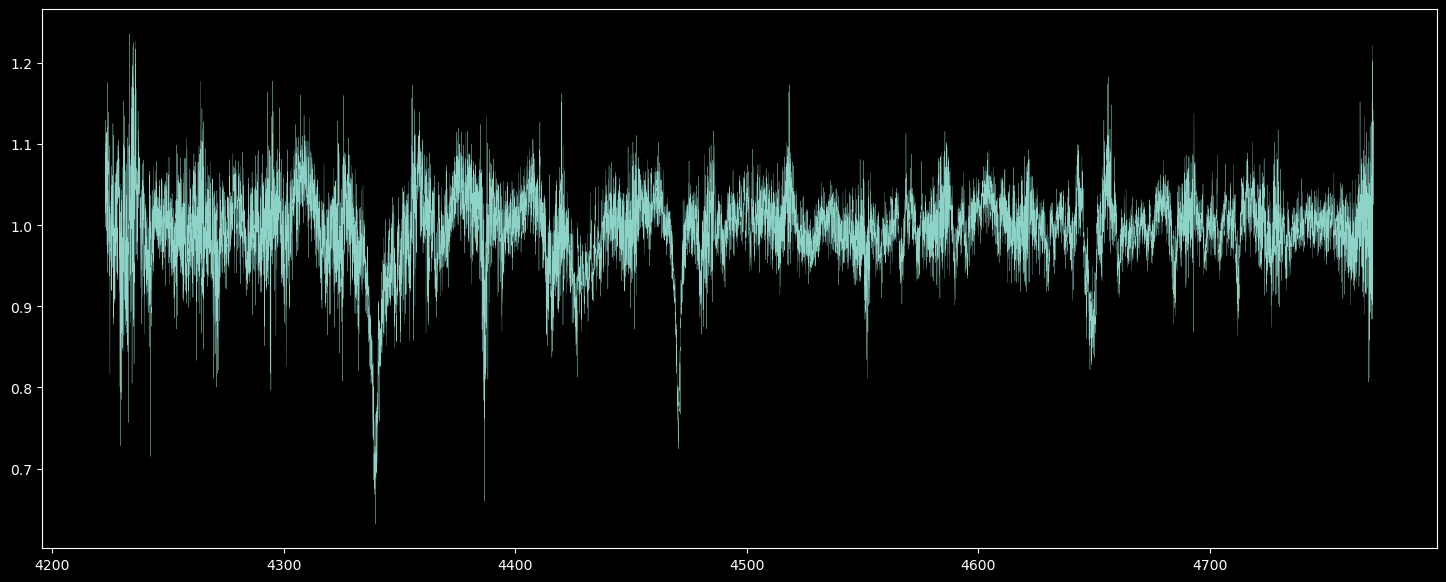

In [107]:
from astropy.io import fits
import matplotlib.pyplot as plt
f = fits.getdata('..\\Files\\202312\\pepsib.20231206.005.dxt.bwl')
# f = fits.getdata('..\\Files\\202312\\pepsir.20231206.017.dxt.bwl')
# f = fits.getdata('..\\Files\\202312\\pepsib.20231206.019.dxt.bwl')
# f = fits.getdata('..\\Files\\202312\\pepsir.20231206.019.dxt.bwl')
#[('Arg', '>f8'), ('Fun', '>f8'), ('Var', '>f8'), ('Mask', 'i1')]
# plt.plot(f['Var'], linewidth=0.2)
# plt.plot(f['Fun'], linewidth=0.2)
plt.figure(figsize=(18, 7))
plt.plot(f['Arg'], f["Fun"], linewidth=0.2)